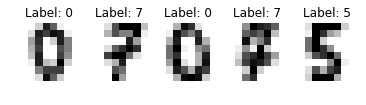

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

digits = datasets.load_digits()
    
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
mnist_data = digits.images.reshape((n_samples, -1))
labels = digits.target

# choose some random images to display
indices = np.arange(len(digits.images))
display = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[display]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[display[i]])
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, labels, train_size=train_to_test_ratio)


/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
from scipy.special import expit
from tqdm import tqdm

class NeuralNetwork:
    def __init__(
        self,
        X_data,
        Y_data,
        epochs=1,
        batch_size=100,
        eta=1e-2,
        lmbd=0.0,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=2,
    ):
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.weights_layer1 = np.random.randn(self.n_features, self.n_neurons_layer1)
        self.bias_layer1 = np.zeros(self.n_neurons_layer1)

        self.weights_layer2 = np.random.randn(self.n_neurons_layer1, self.n_neurons_layer2)
        self.bias_layer2 = np.zeros(self.n_neurons_layer2)

        self.weights_output = np.random.randn(self.n_neurons_layer2, self.n_categories)
        self.bias_output = np.zeros(self.n_categories)

    def feed_forward(self):
        self.z1 = np.dot(self.X_data, self.weights_layer1) + self.bias_layer1
        self.a1 = expit(self.z1)

        self.z2 = np.dot(self.a1, self.weights_layer2) + self.bias_layer2
        self.a2 = expit(self.z2)

        self.z3 = np.dot(self.a2, self.weights_output) + self.bias_output

        exp_term = np.exp(self.z3)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        z1 = np.dot(X, self.weights_layer1) + self.bias_layer1
        a1 = expit(z1)

        z2 = np.dot(a1, self.weights_layer2) + self.bias_layer2
        a2 = expit(z2)

        z3 = np.dot(a2, self.weights_output) + self.bias_output

        exp_term = np.exp(z3)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities
        error_output[range(self.n_inputs), self.Y_data] -= 1
        error_layer2 = (np.dot(error_output, self.weights_output.T) * self.a2 * (1 - self.a2))
        error_layer1 = (np.dot(error_layer2, self.weights_layer2.T) * self.a1 * (1 - self.a1))

        self.weights_output_gradient = np.dot(self.a2.T, error_output)
        self.bias_output_gradient = np.sum(error_output)

        self.weights_layer2_gradient = np.dot(self.a1.T, error_layer2)
        self.bias_layer2_gradient = np.sum(error_layer2)

        self.weights_layer1_gradient = np.dot(self.X_data.T, error_layer1)
        self.bias_layer1_gradient = np.sum(error_layer1)

        if self.lmbd > 0.0:
            self.weights_output_gradient += self.lmbd * self.weights_output
            self.weights_layer2_gradient += self.lmbd * self.weights_layer2
            self.weights_layer1_gradient += self.lmbd * self.weights_layer1

        self.weights_output -= self.eta * self.weights_output_gradient
        self.bias_output -= self.eta * self.bias_output_gradient
        self.weights_layer2 -= self.eta * self.weights_layer2_gradient
        self.bias_layer2 -= self.eta * self.bias_layer2_gradient
        self.weights_layer1 -= self.eta * self.weights_layer1_gradient
        self.bias_layer1 -= self.eta * self.bias_layer1_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.n_inputs = self.X_data.shape[0]

                self.feed_forward()
                self.backpropagation()


In [4]:
from sklearn.metrics import accuracy_score

epochs = 1
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 10

eta_vals = np.logspace(-5, 0, 6)
lmbd_vals = np.logspace(-5, 0, 6)

In [5]:
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NeuralNetwork(X_train, Y_train, eta=eta, lmbd=lmbd, epochs=10, batch_size=batch_size,
                                  n_neurons_layer1=n_neurons_layer1, n_neurons_layer2=n_neurons_layer2,
                                  n_categories=n_categories)
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print()

Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.09722222222222222

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.11388888888888889

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.1

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.06944444444444445

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.15555555555555556

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.10833333333333334

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.16111111111111112

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.20555555555555555

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.19444444444444445

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.18888888888888888

Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.18333333333333332

Learning rate  =  0.0001
La

In [6]:
from sklearn.neural_network import MLPClassifier

DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_neurons_layer1, n_neurons_layer2), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=100)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", dnn.score(X_test, Y_test))
        print()

/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.28055555555555556

Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.09166666666666666

Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.09722222222222222

Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.1111111111111111

Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.09166666666666666

Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.19166666666666668

Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.875

Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.8777777777777778

Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.9166666666666666

Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.9

Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.875

Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on t

In [30]:
import tensorflow as tf

class DNNModel:
    def __init__(
        self,
        X_data,
        Y_data,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=2,
        eta=0.1,
    ):
        self.X_data_full = X_data
        self.Y_data_full = Y_data
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.n_features = X_data.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.eta = eta
        
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_accuracy()
        self.create_optimiser()
    
    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.name_scope('DNN'):
            
            # Fully connected layer 1
            W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, W_fc1) + b_fc1)
            
            # Fully connected layer 2
            W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, W_fc2) + b_fc2)
            
            # Output layer
            W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.z_out))

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y,1), tf.argmax(self.z_out, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            self.accuracy = tf.reduce_mean(correct_prediction)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

In [38]:
DNN = DNNModel(X_train, Y_train, n_neurons_layer1, n_neurons_layer2, n_categories, eta=0.1)

iterations = X_train.shape[0] // batch_size
data_indices = np.arange(X_train.shape[0])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(iterations):
            chosen_datapoints = np.random.choice(data_indices, size=batch_size, replace=False)
            batch_X, batch_Y = X_train[chosen_datapoints], Y_train[chosen_datapoints]
            
            sess.run([DNN.loss, DNN.optimizer],
                    feed_dict={DNN.X: batch_X,
                               DNN.Y: batch_Y})
            

ValueError: Cannot feed value of shape (100,) for Tensor 'data_15/Y_data:0', which has shape '(?, 10)'